## Model Developer Workflow Example

### Using czbenchmarks to evaluate an in-development model on a single task

This section demonstrates how to leverage the czbenchmarks library to generate benchmark metrics for a previously published model (using existing model weights) and integrate `czbenchmarks` into the developer workflow for iterative evaluation of model performance over the course of parameter tuning. 

We focus on the `Cell Clustering` task as an example, but the same approach can be applied to other tasks supported by `czbenchmarks`. For a comprehensive overview of all tasks, refer to the `scvi_all_benchmark_results.ipynb` notebook.

In this example, we use scVI, a popular tool for single-cell analysis, to compare the performance of published model weights against variations obtained through iterative re-training. 

> **NOTE**: This workflow can also be adapted for the development and evaluation of entirely new models.

### Key Highlights:
- **Benchmark Metrics**: Evaluate clustering performance using Adjusted Rand Index (ARI) and Normalized Mutual Information (NMI).
- **Iterative Development**: Demonstrate how to fine-tune model parameters and assess performance improvements.
- **Generalization**: Showcase how the workflow can be extended to other tasks and models.

### Step 1: Setup and Imports

To begin, ensure your environment is properly configured. This includes setting up a virtual environment, installing required dependencies, and registering the environment as a Jupyter kernel. Below is the setup process:

#### Virtual Environment Setup (Optional)
If you need to create a new virtual environment, uncomment and run the commands in cell below


In [16]:
# # Create isolated virtual environment for scVI and czbenchmarks (run once)

# !python3 -m venv .venv_scvi

# # Install model required packages
# !.venv_scvi/bin/python -m pip install --upgrade pip
# !.venv_scvi/bin/python -m pip install ipykernel numpy pandas scvi-tools tabulate matplotlib seaborn

# # Register the new environment as a Jupyter kernel (if not already registered)
# !.venv_scvi/bin/python -m ipykernel install --user --name venv_scvi --display-name "Python (.venv_scvi)"

# print("Virtual environment '.venv_scvi' created, dependencies installed, and kernel registered.")


#### Import Libraries

This notebook requires the following libraries:

- **czbenchmarks**: For dataset loading and task evaluation.
- **scVI**: For model inference and fine-tuning.
- **Visualization tools**: For plotting benchmark results (matplotlib, seaborn, pandas).
- **Logging and warnings**: To configure notebook output and suppress unnecessary messages.


In [17]:
import logging
import sys
from czbenchmarks.datasets import load_dataset
from czbenchmarks.datasets.single_cell_labeled import SingleCellLabeledDataset
from czbenchmarks.tasks import (
    ClusteringTask,
    EmbeddingTask,
    MetadataLabelPredictionTask,
)
from czbenchmarks.tasks.clustering import ClusteringTaskInput
from czbenchmarks.tasks.embedding import EmbeddingTaskInput
from czbenchmarks.tasks.label_prediction import MetadataLabelPredictionTaskInput

# Model specific imports
import scvi  # other imports can be used as required by model
import functools

# --- Visualization Imports ---
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Notebook config imports
import warnings 

warnings.simplefilter('ignore')
sns.set_theme(style="whitegrid")

# Set up basic logging to see the library's output
logging.basicConfig(level=logging.INFO, stream=sys.stdout)

### Step 2: Load a Dataset

In this step, we load the pre-configured `tsv2_prostate` dataset, which is specifically designed for single-cell analysis tasks. The `czbenchmarks` library simplifies this process by automatically handling dataset download, caching, and loading as a `SingleCellLabeledDataset`. This ensures efficient and reproducible workflows for downstream analysis.

### Key Features of the Loaded Dataset:
- **Gene Expression Data (`dataset.adata`)**: The dataset is stored as an AnnData object, a widely used format for single-cell data that includes gene expression matrices and associated metadata.
- **Cell Type Labels (`dataset.labels`)**: A pandas Series containing cell type annotations, which serve as ground truth for benchmarking tasks like clustering and label prediction.

---

> **NOTE**: Always verify that dataset is compatible with the model input requirements before running inference.

In [ ]:
dataset: SingleCellLabeledDataset = load_dataset("tsv2_prostate")
dataset.adata
dataset.labels

#### Step 2.1: Optionally Transform Data

After loading the dataset, you may need to transform the data to meet the requirements of your model.  
Typical transformations include:

- **Batch Correction:** Adjust for batch effects using metadata columns (e.g., donor, assay, suspension type).
- **Normalization:** Scale or normalize gene expression values.
- **Feature Selection:** Select highly variable genes or filter out low-quality cells.
- **Encoding:** Convert categorical metadata to string or numeric codes as needed.

Carefully consider which transformations are appropriate for your analysis and model.  
Below, we demonstrate batch key construction for downstream tasks.


In [ ]:

required_obs_keys = ["dataset_id", "assay", "suspension_type", "donor_id"]
adata = dataset.adata.copy()

batch_keys = required_obs_keys
adata.obs["batch"] = functools.reduce(
    lambda a, b: a + b, [adata.obs[c].astype(str) for c in batch_keys]
)

### Step 3: Obtain Pre-trained Model, Run Model Inference, and Generate Output

In this step, we leverage the pre-trained scVI model to generate cell embeddings for evaluation within the benchmarking framework. The pre-trained model weights serve as a reference point for comparison against fine-tuned or newly developed model variants.

#### Key Steps:
1. **Load Pre-trained Model Weights**: Use the scVI API to load the model weights associated with the reference model.
2. **Prepare Dataset for Inference**: Ensure the dataset is compatible with the pre-trained model by mapping it to the required format using scVI's `prepare_query_anndata` function.
3. **Generate Latent Representations**: Extract cell embeddings (latent representations) from the model, which will be used for downstream benchmarking tasks.

---

> **NOTE**: For your own model, adapt the loading and inference steps to match your model's requirements. 

In [ ]:
# Download pre-trained model weights from S3
import os
import boto3

# Change locaation of model weights as needed
local_model_dir = "czbenchmarks_scvi_model"
if not os.path.exists(local_model_dir):
    os.makedirs(local_model_dir, exist_ok=True)

if not os.listdir(local_model_dir):
    s3 = boto3.client("s3")
    bucket_name = "cz-benchmarks-data"
    prefix = "models/v1/scvi_2023_12_15/homo_sapiens/"
    print("Downloading model weights from S3...")
    paginator = s3.get_paginator("list_objects_v2")
    for page in paginator.paginate(Bucket=bucket_name, Prefix=prefix):
        for obj in page.get("Contents", []):
            key = obj["Key"]
            if key.endswith("/"):
                continue
            local_path = os.path.join(local_model_dir, os.path.relpath(key, prefix))
            os.makedirs(os.path.dirname(local_path), exist_ok=True)
            s3.download_file(bucket_name, key, local_path)
    print(f"Downloaded model weights to {local_model_dir} \n")

model_weights_dir = local_model_dir

# Use the scvi-tools API to map our dataset to the reference model
scvi.model.SCVI.prepare_query_anndata(adata, model_weights_dir)
scvi_model = scvi.model.SCVI.load_query_data(adata, model_weights_dir)
scvi_model.is_trained = True  # Ensure the model is marked as trained

# Now, generate the latent representation (the embedding)
scvi_embedding = scvi_model.get_latent_representation()
original_model_output = scvi_embedding

print(f"Generated scVI embedding with shape: {scvi_embedding.shape}")

INFO     File czbenchmarks_scvi_model/model.pt already downloaded                                                  
INFO     Found 44.05% reference vars in query data.                                                                
INFO     File czbenchmarks_scvi_model/model.pt already downloaded                                                  
Generated scVI embedding with shape: (2044, 50)


### Step 4: Run the Clustering Task for Both Pre-trained and In-development Model Variants

In this step, we evaluate the quality of the embeddings generated by the models using the `ClusteringTask` from `czbenchmarks`. This task measures clustering performance using two widely recognized metrics:

- **Adjusted Rand Index (ARI)**: Quantifies the similarity between the predicted clusters and the ground truth labels, adjusted for chance.
- **Normalized Mutual Information (NMI)**: Measures the mutual dependence between predicted clusters and ground truth labels, normalized to ensure comparability across datasets.

The task compares Leiden clusters derived from the embeddings to the true labels provided in the dataset. Higher scores for ARI and NMI indicate better clustering performance.


#### Step 4.1. **Pre-trained Model Evaluation**: Benchmark the clustering performance of the embeddings generated by the pre-trained scVI model.

In [20]:
# Task step 1. Initialize the task
clustering_task = ClusteringTask()

# Task step 2. Define the inputs for the task
clustering_task_input = ClusteringTaskInput(
    obs=dataset.adata.obs,
    input_labels=dataset.labels,
)

benchmark_results = {} # dictionary to store benchmark results for all evaluations

# Task step 3. Run the task on the original model
original_clustering_results = clustering_task.run(
    cell_representation=original_model_output,
    task_input=clustering_task_input
)

# Add results to the results dictionary for future comparison
oc_results = [i.model_dump() for i in original_clustering_results]
benchmark_results["original"] = {oc_results[0]['metric_type']: oc_results[0]['value'],
                                 oc_results[1]['metric_type']: oc_results[1]['value']}



#### Step 4.2. **Baseline Comparison**: Compute clustering metrics for a baseline method (e.g., PCA) to establish a reference point for comparison.

In [21]:
# Compute and run the baseline for comparison
expression_data = dataset.adata.X
clustering_baseline = clustering_task.compute_baseline(expression_data)
clustering_baseline_results = clustering_task.run(
    cell_representation=clustering_baseline,
    task_input=clustering_task_input,
) 

# Add baseline results to the results dictionary for future comparison
base = [i.model_dump() for i in clustering_baseline_results]
benchmark_results["baseline"] = {base[0]['metric_type']: base[0]['value'],
                                 base[1]['metric_type']: base[1]['value']}

#### Step 4.3. **Iterative Model Evaluation**: Extend the workflow to evaluate clustering performance for fine-tuned or newly developed model variants.

##### **Demo**: Fine-Tune the Model - Simulating Iterative Parameter Updates

To showcase how `czbenchmarks` can be integrated into the model development process, we simulate an iterative development lifecycle by generating scVI model variants with different parameterizations. 

Key Steps:
1. **Generate Model Variants**: Create multiple versions of the scVI model by varying key parameters (e.g., latent dimensions).
2. **Train Each Variant**: Fine-tune each model variant using the scVI training API with customized training configurations.
3. **Evaluate Performance**: Use `czbenchmarks` to compute benchmark metrics for each variant, enabling comparison across iterations.


In [22]:
# Demo function to simulate fine-tuning of a model, here using scVI as an example
def fine_tune_model(latent_param):

    # create a new iteration of this model with different parameters
    this_model_version = scvi.model.SCVI(adata, n_latent=latent_param) 
    this_model_version.train(
        max_epochs=10, 
        plan_kwargs={"lr": 0.0005},
        early_stopping=True,
        early_stopping_patience=10
    )
    
    print("Model update complete.")
    
    return this_model_version

**Demonstrating Iterative Model Evaluation with czbenchmarks**

In this section, we showcase how `czbenchmarks` can be used to evaluate the performance of updated model variants in an iterative development workflow. Using the `fine_tune_model` function, we simulate parameter updates by looping through multiple configurations (e.g., `n_hidden` = [32, 64, 128]) and assess the impact of these changes on clustering performance.


In [23]:
# ---------------------------------------------------------------
# Iterative Model Variant Evaluation:
#
# Note: Here, we optimize the model by varying the latent dimension (n_latent),
# but this workflow can be adapted to test other model parameters or architectures.
# ---------------------------------------------------------------

latent_param_to_test = [3, 5, 10, 25]

for e in latent_param_to_test:

    # Fine-tune the model
    tuned_model = fine_tune_model(e)

    # Generate the latent representation from the *fine-tuned* model
    fine_tuned_model_output = tuned_model.get_latent_representation()
    
    print(f"Generated fine-tuned scVI embedding with shape: {fine_tuned_model_output.shape}")

    # 3. Run the task on this model variant's output
    clustering_results = clustering_task.run(
        cell_representation=fine_tuned_model_output,
        task_input=clustering_task_input,
    )

    # Add results to the results dictionary for future comparison 
    this_result = [i.model_dump() for i in clustering_results]
    benchmark_results[f"nlayers_{e}"] = {this_result[0]['metric_type']: this_result[0]['value'],
                                       this_result[1]['metric_type']: this_result[1]['value']}


INFO: GPU available: True (mps), used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (mps), used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Epoch 10/10: 100%|██████████| 10/10 [00:09<00:00,  1.03it/s, v_num=1, train_loss_step=3.07e+3, train_loss_epoch=2.79e+3]

INFO: `Trainer.fit` stopped: `max_epochs=10` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 10/10: 100%|██████████| 10/10 [00:09<00:00,  1.04it/s, v_num=1, train_loss_step=3.07e+3, train_loss_epoch=2.79e+3]

INFO: GPU available: True (mps), used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (mps), used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs



Model update complete.
Generated fine-tuned scVI embedding with shape: (2044, 3)
Epoch 10/10: 100%|██████████| 10/10 [00:08<00:00,  1.15it/s, v_num=1, train_loss_step=2.77e+3, train_loss_epoch=2.74e+3]

INFO: `Trainer.fit` stopped: `max_epochs=10` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 10/10: 100%|██████████| 10/10 [00:08<00:00,  1.13it/s, v_num=1, train_loss_step=2.77e+3, train_loss_epoch=2.74e+3]

INFO: GPU available: True (mps), used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (mps), used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs



Model update complete.
Generated fine-tuned scVI embedding with shape: (2044, 5)
Epoch 10/10: 100%|██████████| 10/10 [00:08<00:00,  1.13it/s, v_num=1, train_loss_step=2.54e+3, train_loss_epoch=2.78e+3]

INFO: `Trainer.fit` stopped: `max_epochs=10` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 10/10: 100%|██████████| 10/10 [00:08<00:00,  1.13it/s, v_num=1, train_loss_step=2.54e+3, train_loss_epoch=2.78e+3]

INFO: GPU available: True (mps), used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (mps), used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs



Model update complete.
Generated fine-tuned scVI embedding with shape: (2044, 10)
Epoch 10/10: 100%|██████████| 10/10 [00:08<00:00,  1.11it/s, v_num=1, train_loss_step=2.61e+3, train_loss_epoch=2.78e+3]

INFO: `Trainer.fit` stopped: `max_epochs=10` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 10/10: 100%|██████████| 10/10 [00:09<00:00,  1.11it/s, v_num=1, train_loss_step=2.61e+3, train_loss_epoch=2.78e+3]
Model update complete.
Generated fine-tuned scVI embedding with shape: (2044, 25)


**Print Benchmark Results Across Model Variants**

The benchmark results provide a comparative analysis of clustering performance across different model configurations:

- **Established Model Variant (`scVI original`)**: Represents the pre-trained scVI model using default parameters.
- **Experimental Model Variants (`nlayers_32`, `nlayers_64`, `nlayers_128`)**: Fine-tuned scVI models with varying latent dimensions, showcasing the impact of architectural changes.
- **Baseline Method (`PCA`)**: Serves as a reference point for evaluating the effectiveness of scVI embeddings compared to a standard dimensionality reduction technique.

In [24]:
pd.DataFrame(benchmark_results).head()

,original,baseline,nlayers_3,nlayers_5,nlayers_10,nlayers_25
MetricType.ADJUSTED_RAND_INDEX,0.728258,0.626707,0.470535,0.537191,0.488317,0.582589
MetricType.NORMALIZED_MUTUAL_INFO,0.869382,0.832648,0.698965,0.748169,0.722576,0.766861


**Visualizing Benchmark Results Across Model Variants**

The results are visualized using bar plots, highlighting the Adjusted Rand Index (ARI) and Normalized Mutual Information (NMI) scores for each model variant. Higher scores indicate better clustering performance, enabling a clear comparison of model effectiveness.

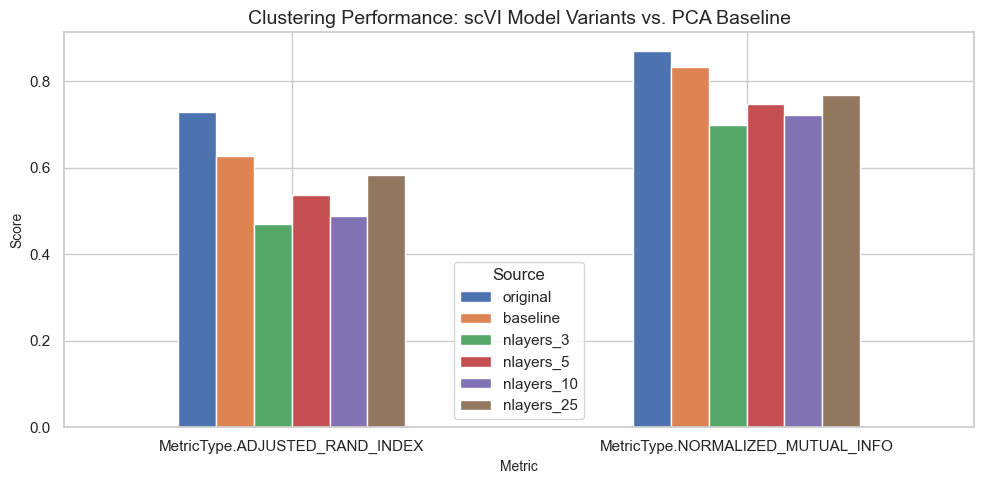

In [25]:
pd.DataFrame(benchmark_results).plot.bar(figsize=(10,5))
plt.title("Clustering Performance: scVI Model Variants vs. PCA Baseline", fontsize=14)
plt.ylabel("Score", fontsize=10)
plt.xlabel("Metric", fontsize=10)
plt.xticks(rotation=0)
plt.legend(title="Source")
plt.tight_layout()
plt.show()